In [1]:
# Set up the environment¶

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_session.region_name

role = get_execution_role()

In [2]:
#Download the MNIST dataset¶

import utils
from tensorflow.contrib.learn.python.learn.datasets import mnist
import tensorflow as tf

data_sets = mnist.read_data_sets('data', dtype=tf.uint8, reshape=False, validation_size=5000)

utils.convert_to(data_sets.train, 'train', 'data')
utils.convert_to(data_sets.validation, 'validation', 'data')
utils.convert_to(data_sets.test, 'test', 'data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Writing data/train.tfrecords

Writing data/validation.tfrecords

In [3]:
# Upload the data¶

inputs = sagemaker_session.upload_data(path='data', key_prefix='data/DEMO-mnist')

In [4]:
# Construct a script for distributed training

!cat 'mnist.py'

import os
import tensorflow as tf
from tensorflow.python.estimator.model_fn import ModeKeys as Modes

INPUT_TENSOR_NAME = 'inputs'
SIGNATURE_NAME = 'predictions'

LEARNING_RATE = 0.001


def model_fn(features, labels, mode, params):
    # Input Layer
    input_layer = tf.reshape(features[INPUT_TENSOR_NAME], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.d

In [6]:
# Create an estimator

from sagemaker.tensorflow import TensorFlow

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             framework_version='1.12.0',
                             training_steps=1000, 
                             evaluation_steps=100,
                             train_instance_count=2,
                             train_instance_type='ml.c4.xlarge')

mnist_estimator.fit(inputs)

tensorflow py2 container will be deprecated soon.


2019-12-24 00:47:51 Starting - Starting the training job...
2019-12-24 00:47:53 Starting - Launching requested ML instances...
2019-12-24 00:48:51 Starting - Preparing the instances for training............
2019-12-24 00:50:50 Downloading - Downloading input data
2019-12-24 00:50:50 Training - Downloading the training image..2019-12-24 00:51:02,933 INFO - root - running container entrypoint
2019-12-24 00:51:02,933 INFO - root - starting train task
2019-12-24 00:51:02,946 INFO - container_support.training - Training starting
2019-12-24 00:51:05,743 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2019-12-24 00:51:05,743 INFO - tf_container - {"environment": "cloud", "cluster": {"worker": ["algo-2:2222"], "ps": ["algo-1:2223", "algo-2:2223"], "master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2019-12-24 00:51:05,743 INFO - tf_container - ---------------------------------------------------------
2019-12-24 00:51:05,743 INFO - tf_container - 

In [7]:
# SageMaker's transformer class

transformer = mnist_estimator.transformer(instance_count=1, instance_type='ml.m4.xlarge')

The Python 2 tensorflow images will be soon deprecated and may not be supported for newer upcoming versions of the tensorflow images.
Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [ ]:
# Run a batch transform job

input_bucket_name = 'sagemaker-sample-data-{}'.format(region)
input_file_path = 'batch-transform/mnist-1000-samples'

transformer.transform('s3://{}/{}'.format(input_bucket_name, input_file_path), content_type='text/csv')

transformer.wait()

.............

In [9]:
# Download the results

print(transformer.output_path)

# Now let's download the first ten results from S3:

import json
from six.moves.urllib import parse

import boto3

parsed_url = parse.urlparse(transformer.output_path)
bucket_name = parsed_url.netloc
prefix = parsed_url.path[1:]

s3 = boto3.resource('s3')

predictions = []
for i in range(10):
    file_key = '{}/data-{}.csv.out'.format(prefix, i)

    output_obj = s3.Object(bucket_name, file_key)
    output = output_obj.get()["Body"].read().decode('utf-8')

    predictions.extend(json.loads(output)['outputs']['classes']['int64Val'])

s3://sagemaker-us-east-2-371990375707/sagemaker-tensorflow-2019-12-24-00-47-5-2019-12-24-00-53-17-099


7, 2, 1, 0, 4, 1, 4, 9, 5, 9


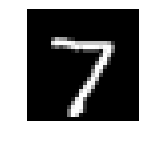

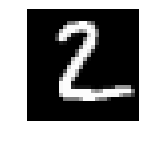

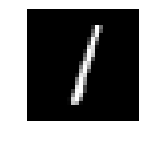

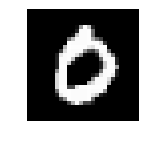

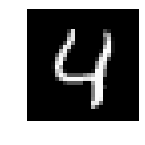

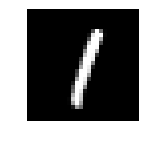

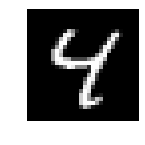

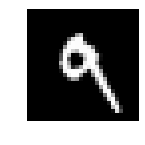

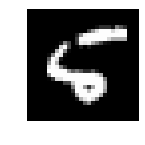

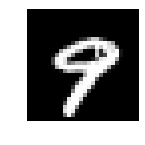

In [11]:
# For demonstration purposes, we're also going to download the corresponding original input data so that we can see how the model did with its predictions.

import os

import matplotlib.pyplot as plt
from numpy import genfromtxt

plt.rcParams['figure.figsize'] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _,(subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

tmp_dir = '/tmp/data'
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

for i in range(10):
    input_file_name = 'data-{}.csv'.format(i)
    input_file_key = '{}/{}'.format(input_file_path, input_file_name)
    
    s3.Bucket(input_bucket_name).download_file(input_file_key, os.path.join(tmp_dir, input_file_name))
    input_data = genfromtxt(os.path.join(tmp_dir, input_file_name), delimiter=',')

    show_digit(input_data)
    

print(', '.join(predictions))